# Test Controlled SMC

Test Controlled SMC algorithm on linear gaussian model. For more details on ControlledSMC  models, see the article: https://arxiv.org/abs/1708.08396

Steps to define a ControlledSMC model 
Step 1 : - Define your own model (for example a state space model [See basic tutorial lesson]). For example ssm = myModel() 
         
Step 2 :  Create the ControlledSMC object as follow:
 
        myCtrlSMC = cSMC.ControlledSMC(ssm=myModel, data = data, iterations = 5)
          ssm: your original defined model 
          data: is your data
          iterations:  iteration to stop the algorithm

 
## Defining a state-space model and Policy functions

We start by importing some standard libraries, plus some modules from the particles package and the controlled smc module.

In [29]:
import warnings; warnings.simplefilter('ignore')  # hide warnings 

# standard libraries
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sb

# modules from particles
import particles  # core module
from particles import distributions as dists  # where probability distributions are defined
from particles import state_space_models as ssm  # where state-space models are defined
from particles.collectors import Moments 
from particles import controlled_smc as cSMC # where controlled smc models are defined

We will test the controlled SMC algorithm on a  linear gaussian state-space model.  It is not required to define a policy function.  

\begin{align*}
X_0 & \sim N\left(0, \frac{\sigma_X^2}{(1-\rho^2)}\right), &\\
X_t|X_{t-1}=x_{t-1} & \sim N\left(   \rho   x_{t-1}, \sigma_X^2\right), &\quad t\geq 1, \\
Y_t|X_t=x_t & \sim N\left(x_{t}, \sigma_Y^2\right),& \quad t\geq 0.
\end{align*}

Note that this model depends on fixed parameter $\theta = (\sigma_X, \rho, \sigma_Y)$. 

If you want to define a  policy function $P_t$, it should have the following structure:

$$
\log P_t(t, X_{t-1}, X_{t})   =  -[(A_t X_{t},X_{t}) + (B_t,X_{t}) + c_t]  
$$ 

where $A_t \geq 0 $, $B_t$, $c_t$ are  scalars. The policy function should return  only the coefficients  $A_t$, $B_t$, $c_t$.

In [30]:
#  DEFINE LINEAR GAUSSIAN MODEL
# -----------------------------
N = 150 # 
class LinearGaussian(ssm.StateSpaceModel):  
    mu =  -1.0; sigmaX = 1.0;   sigmaY = 0.1; rho = 0.9 
    def PX0(self):  # Distribution of X_0
      return  dists.Normal( loc =  0, scale = self.sigmaX/np.sqrt((1- self.rho**2)))
    #   return  dists.Normal( loc = 1.5, scale=2)
    
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}=xp (p=past)
        return  dists.Normal(loc=self.rho * xp , scale=self.sigmaX)

    def PY(self, t, xp, x): # Distribution of Y_t given X_t=x (and possibly X_{t-1}=xp)
         return dists.Normal(loc = x, scale = self.sigmaY)
  
    def policy(self, t): # this methode is optional to define.
        """ return only coefs of the quadratic policy function
            log(policy(t, xp, x)) =  -[(A_t x,x) + (B_t,x) + c_t] - F(xp); where  A_t is a matrix dxd, B_t a d-vector, c_t a scalar  
            The definition of this function  is optional. 
        """
        return 0.0, 0.0, 0.0

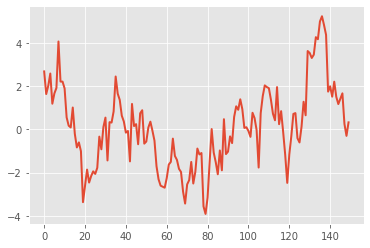

In [54]:
# define the model
linearModel = LinearGaussian() 
true_states, data = linearModel.simulate(N)  # we simulate from the model N data points
plt.style.use('ggplot')
plt.figure()
plt.plot(data, linewidth = 2)

#  Twisted feynman kac model and Bootstrap - simulations  comparison  

 


In [32]:
# define the corresponding Bootstrap model
fk_Bootstrap= ssm.Bootstrap(ssm=linearModel, data=data)   

 # define the corresponding TwistedFK (feynman kac) model
fk_TwistedFK  = cSMC.TwistedFK(ssm=linearModel, data=data)
  
# Bootstrap    
pfBootstrap = particles.SMC(fk=fk_Bootstrap, N=N, resampling='multinomial', collect=[Moments()], store_history=True)  # the algorithm
pfBootstrap.run()  # actual computation

# Twisted SMC 
pfTwisted = particles.SMC(fk=fk_TwistedFK, N=N, resampling='multinomial', collect=[Moments()], store_history=True)  # the algorithm
pfTwisted.run()  # actual computation


Text(0.5, 1.0, 'Weighted histogram of the particles')

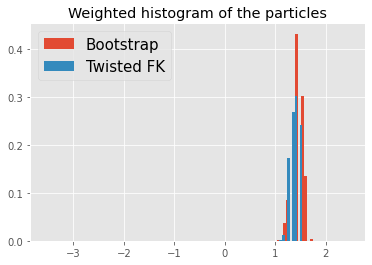

In [33]:
# Weighted histogram of the particles  
plt.figure()
plt.hist(pfBootstrap.X, 100, weights=pfBootstrap.W)
plt.hist(pfTwisted.X, 100, weights=pfTwisted.W)
plt.legend(['Bootstrap', 'Twisted FK'], fontsize = 15)
plt.title('Weighted histogram of the particles')

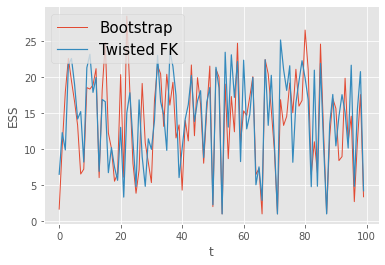

In [34]:
# ESSs
plt.figure()
plt.plot(pfBootstrap.summaries.ESSs, linewidth = 1)
plt.plot(pfTwisted.summaries.ESSs, linewidth = 1.2)
plt.xlabel('t')
plt.ylabel('ESS')
plt.legend(['Bootstrap', 'Twisted FK'], fontsize = 15)


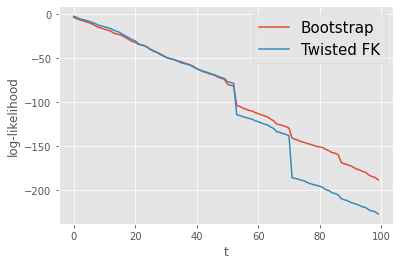

In [35]:
# log-likelihood
plt.figure()
plt.plot(pfBootstrap.summaries.logLts)
plt.plot(pfTwisted.summaries.logLts)
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.legend(['Bootstrap', 'Twisted FK'], fontsize = 15)
 

Text(0.5, 1.0, 'Boxplot')

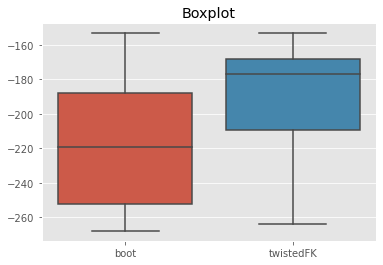

In [36]:
# Boxplot
outf = lambda pf: pf.logLt
results = particles.multiSMC(fk={'boot':fk_Bootstrap, 'twistedFK':fk_TwistedFK}, 
                             nruns=10, nprocs=1, out_func=outf)
plt.figure()
sb.boxplot(x=[r['fk'] for r in results],  y=[r['output'] for r in results])
plt.title('Boxplot')

## Controlled smc - Feynman kac model  results 

In [55]:
maxTime = 150
myiter = 2
PsiSMC = cSMC.ControlledSMC(ssm=linearModel, data = data, maxTime = maxTime, iterations = myiter)  

# Run controlled SMC algorithm
cSMChist,  cSMCsummaries = PsiSMC.RunAll()

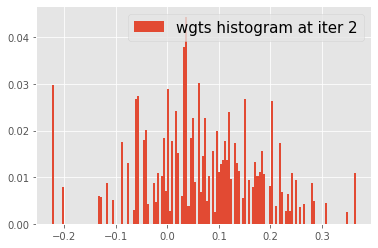

In [56]:
# Weighted histogram of the particles
plt.figure()
plt.hist(cSMChist.X[maxTime-1], N, weights=cSMChist.wgts[maxTime-1].W)
plt.legend(['wgts histogram at iter ' + str(myiter)], fontsize = 15)

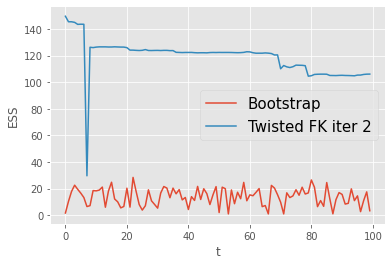

In [57]:
# ESSs
plt.figure()
plt.plot(pfBootstrap.summaries.ESSs) 
plt.plot(cSMCsummaries.ESSs) 
plt.xlabel('t')
plt.ylabel('ESS')
plt.legend(['Bootstrap', 'Twisted FK iter ' + str(myiter)], fontsize = 15)

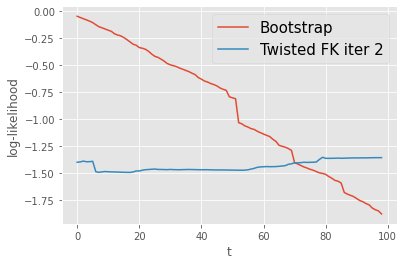

In [58]:
# log-likelihood
plt.figure()
plt.plot(np.array(pfBootstrap.summaries.logLts)[1:]/100)
plt.plot(np.array(cSMCsummaries.logLts)[1:]/100)
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.legend(['Bootstrap', 'Twisted FK iter '+str(myiter)], fontsize = 15)


In [37]:
maxTime = 100
myiter = 3
PsiSMC = cSMC.ControlledSMC(ssm=linearModel, data = data, maxTime = maxTime, iterations = myiter)  

# Run controlled SMC algorithm
cSMChist,  cSMCsummaries = PsiSMC.RunAll()

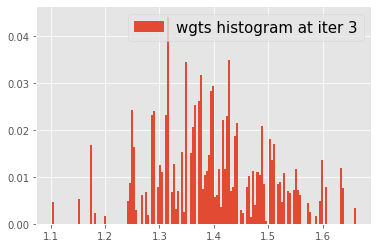

In [38]:
# Weighted histogram of the particles
plt.figure()
plt.hist(cSMChist.X[maxTime-1], N, weights=cSMChist.wgts[maxTime-1].W)
plt.legend(['wgts histogram at iter ' + str(myiter)], fontsize = 15)

In [ ]:
# Weighted histogram of the particles
plt.figure()
plt.hist(cSMChist.X[maxTime-1], N, weights=cSMChist.wgts[maxTime-1].W)
plt.legend(['wgts histogram at iter ' + str(myiter)], fontsize = 15)

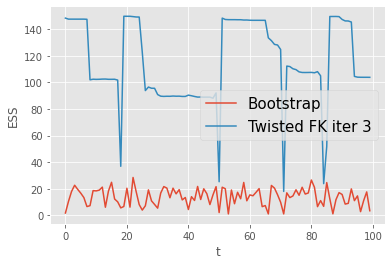

In [39]:
# ESSs
plt.figure()
plt.plot(pfBootstrap.summaries.ESSs) 

plt.plot(cSMCsummaries.ESSs) 
plt.xlabel('t')
plt.ylabel('ESS')
plt.legend(['Bootstrap', 'Twisted FK iter ' + str(myiter)], fontsize = 15)

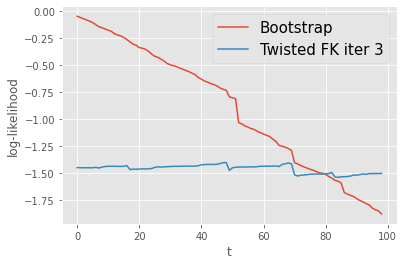

In [40]:
# log-likelihood
plt.figure()
plt.plot(np.array(pfBootstrap.summaries.logLts)[1:]/100)
plt.plot(np.array(cSMCsummaries.logLts)[1:]/100)
plt.xlabel('t')
plt.ylabel('log-likelihood')
plt.legend(['Bootstrap', 'Twisted FK iter '+str(myiter)], fontsize = 15)


## Particle Smoothing

 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


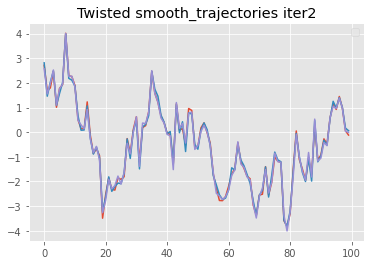

In [59]:

smooth_trajectories = cSMChist.backward_sampling(3) # 10 Trajectories
plt.figure()
plt.plot(smooth_trajectories)
plt.title("Twisted smooth_trajectories iter" +str(myiter))
plt.legend()